# GCE Lab 4 - Dwarf Galaxy - Chemical Evolution Trend

In this notebook, you will tune model parameters to fit the chemical evolution trend derived from stellar spectroscopy, for the dwarf spheroidal galaxy Fornax.

In [10]:
# Import standard Python packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path  # file-system utilities for relative data access
import sys  # manipulate Python path for project imports

# root paths help resolve data assets and allow local imports
repo_root = Path('..').resolve()  # repository base used to resolve data files
package_root = repo_root.parent  # NuPyCEE package resides one directory above
if str(package_root) not in sys.path:  # keep sys.path modification idempotent
    sys.path.insert(0, str(package_root))  # register NuPyCEE package for imports

# One-zone galactic chemical evolution code
import NuPyCEE.omega as omega

# Stellar abundances plotting code
import NuPyCEE.stellab as stellab

# Matplotlib option
%matplotlib inline

## 1. Stellar Abundances

To plot the observed stellar abundances of a galaxy, STELLAB first needs to be launched without input parameter.

In [5]:
# Launch the STELLAB code
s = stellab.stellab()

The next step is to select a galaxy. So far, STELLAB includes the Milky Way, Sculptor, Carina, Fornax, and the LMC. Simply use the galaxy parameter and enter the name of the galaxy with lower cases (spaces need to be replaced by underscores). Then, use the plot_spectro function to visualize the selected abundance ratios.

In [11]:
# observational Eu catalog for Fornax (Reichert et al. 2020)
reichert_csv = repo_root / "observations" / "reichert2020_for.csv"  # processed observational dataset

if not reichert_csv.exists():  # guard against missing input file
    raise FileNotFoundError(
        "Missing observations/reichert2020_for.csv. ",
        "Run observations/generate_reichert2020_for_csv.py to build it.",
    )

obs_df = pd.read_csv(reichert_csv)  # load observational measurements into DataFrame
obs_df = obs_df.rename(columns={"ID": "star"})  # adopt clearer star identifier label
obs_df = obs_df.dropna(subset=["[Fe/H]", "[Eu/Fe]"])  # keep entries with complete abundance info
# ensure only stars with both Fe and Eu remain
obs_df = obs_df.sort_values("[Fe/H]").reset_index(drop=True)  # order by metallicity for plotting

print(f"Loaded {len(obs_df)} Reichert et al. (2020) Fornax stars with Eu measurements")  # quick sanity check
obs_df[["star", "[Fe/H]", "[Eu/Fe]", "sigma_Eu", "sigma_Fe"]].head()  # preview top entries

Loaded 108 Reichert et al. (2020) Fornax stars with Eu measurements


,star,[Fe/H],[Eu/Fe],sigma_Eu,sigma_Fe
0,[LDH2014] Fnx-mem0654,-1.64,0.31,0.15,0.06
1,[LDH2014] Fnx-mem0612,-1.54,0.48,0.14,0.07
2,[LHT2010] BL147,-1.50,0.98,0.31,0.05
3,[LDH2014] Fnx-mem0747,-1.35,0.69,0.10,0.06
4,[LDH2014] Fnx-mem0647,-1.34,0.19,0.07,0.07


In [36]:
obs_df.keys()

Index(['star', 'Galaxy', '[Fe/H]', 'e_[Fe/H]', 'logeps(Eu)', 'e_tot(Eu)',
       'e_temp(Eu)', 'e_logg(Eu)', 'e_[Fe/H](Eu)', 'e_v(Eu)', 'e_stat(Eu)',
       'e_noise(Eu)', '[Eu/H]', '[Eu/Fe]', 'sigma_Fe', 'sigma_Eu'],
      dtype='object')

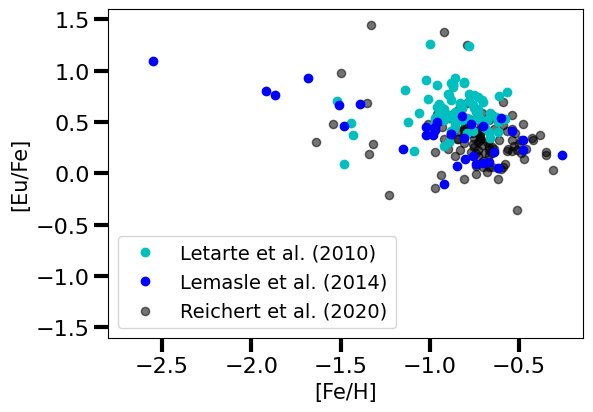

In [15]:
# Select the galaxy
galaxy = "fornax"

# Plot the abundance ratios
matplotlib.rcParams.update({'font.size': 16.0})
s.plot_spectro(galaxy=galaxy, xaxis='[Fe/H]', yaxis='[Eu/Fe]')
plt.ylim(-1.6, 1.6)
plt.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')
plt.legend()

## 2. Fit Stellar Abundances with Models

In [33]:
# \\\\\\\\\\ Modify below \\\\\\\\\\\\
# ====================================

# Define the galactic chemical evolution (GCE) parameters

# Dimensionless star formation efficiency (must be below 1.0)
# Original value --> 0.3
sfe = 0.3          

# Strength of galactic outflows
# Original value --> 2.0
mass_loading = 2.0   

# Number of Type Ia supernova that occurs per stellar mass formed
# Original value --> 0.4e-3
nb_1a_per_m = 0.4e-3

# ====================================
# ////////// Modify above ////////////

# Run the GCE code OMEGA
o_1 = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                  nb_1a_per_m=nb_1a_per_m, transitionmass=10.0)

OMEGA run in progress..
..Time refinement..
   OMEGA run completed - Run time: 1.18s


(-3.2, 0.2)

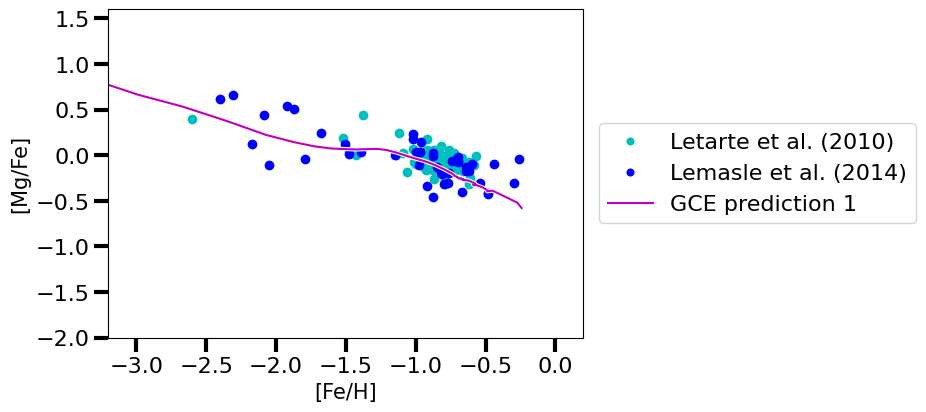

In [41]:
# Choose your elemental abundance ratios
yaxis = '[Mg/Fe]'
xaxis = '[Fe/H]'

# Plot stellar abundances derived from observations
matplotlib.rcParams.update({'font.size': 16.0})
s.plot_spectro(galaxy=galaxy, xaxis=xaxis, yaxis=yaxis)
#plt.scatter(obs_df['[Fe/H]'], obs_df['[Mg/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')

# Overplot the predictions on top of observations
xy_0_1 = o_1.plot_spectro(xaxis=xaxis, yaxis=yaxis, return_x_y=True)
plt.plot(xy_0_1[0],  xy_0_1[1],  color='w', linewidth=3.0)
plt.plot(xy_0_1[0],  xy_0_1[1],  color='m', linewidth=1.5, label='GCE prediction 1')

# Update the legend and set the X and Y axis limits.
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), markerscale=0.8, fontsize=16)
plt.ylim(-2, 1.6)
plt.xlim(-3.2, 0.2)

Prediction is not universal across different elements, e.g. above works well for Mg but not for e.g. Ba, Eu. 

- Different elements come from different nucleosynthetic sites with different timescales and rates. Mg is an alpha element produced rapidly and copiously by core-collapse SNe, so its evolution closely traces the star-formation history and is relatively easy to match with smooth one‑zone models.
- Eu and many heavy elements are produced by rare, delayed events (e.g., neutron-star mergers) or by AGB stars (s‑process). Their yields, event rates and delay‑time distributions are uncertain and can be very stochastic in low‑mass systems, so the same global GCE parameters that fit Mg need not reproduce Eu/Ba.
- Model assumptions matter: nucleosynthetic yield sets, whether r‑process sites are included, delay-time distributions (DTDs) for SNe Ia/mergers, instantaneous mixing vs. stochastic/local enrichment, and outflow/inflow prescriptions all change [X/Fe] tracks differently for different elements.

In [69]:
# \\\\\\\\\\ Modify below \\\\\\\\\\\\
# ====================================

# Define the galactic chemical evolution (GCE) parameters

# Dimensionless star formation efficiency (must be below 1.0)
# Original value --> 0.3
sfe = 0.99         

# Strength of galactic outflows
# Original value --> 2.0
mass_loading = 0.01

# Number of Type Ia supernova that occurs per stellar mass formed
# Original value --> 0.4e-3
nb_1a_per_m = 0.01e-3

# ====================================
# ////////// Modify above ////////////

# Run the GCE code OMEGA
o_2 = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                  nb_1a_per_m=nb_1a_per_m, transitionmass=10.0)

OMEGA run in progress..
..Time refinement..
Warning - Negative inflow.  The outflow rate has been increased. 133
Warning - Negative inflow.  The outflow rate has been increased. 134
Warning - Negative inflow.  The outflow rate has been increased. 135
Warning - Negative inflow.  The outflow rate has been increased. 136
   OMEGA run completed - Run time: 2.5s


(-3.2, 0.2)

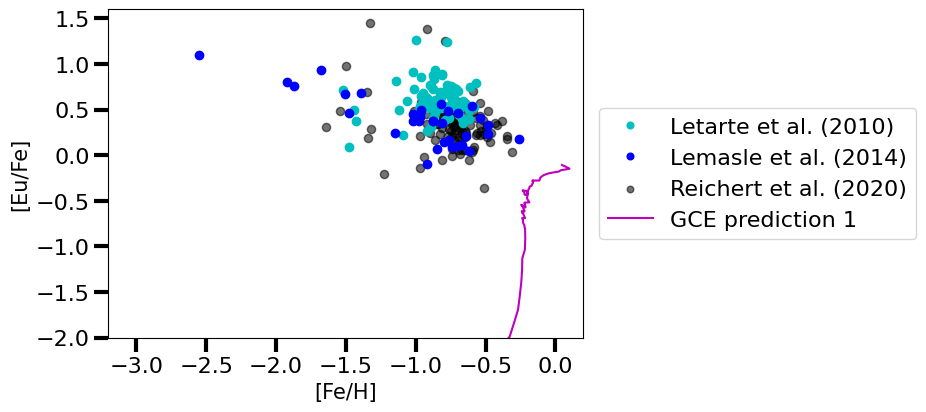

In [70]:
# Choose your elemental abundance ratios
yaxis = '[Eu/Fe]'
xaxis = '[Fe/H]'

# Plot stellar abundances derived from observations
matplotlib.rcParams.update({'font.size': 16.0})
s.plot_spectro(galaxy=galaxy, xaxis=xaxis, yaxis=yaxis)
plt.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')

# Overplot the predictions on top of observations
xy_0_1 = o_2.plot_spectro(xaxis=xaxis, yaxis=yaxis, return_x_y=True)
plt.plot(xy_0_1[0],  xy_0_1[1],  color='w', linewidth=3.0)
plt.plot(xy_0_1[0],  xy_0_1[1],  color='m', linewidth=1.5, label='GCE prediction 1')

# Update the legend and set the X and Y axis limits.
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), markerscale=0.8, fontsize=16)
plt.ylim(-2, 1.6)
plt.xlim(-3.2, 0.2)

## Exercises

* 1) Try to modify **mass_loading**, the strength of galactic outflows (how much gas is removed from the galaxy). Develop an intuition on how outflows affect the numerical predictions.


* 2) Do the same thing with **nb_1a_per_m**, the number of Type Ia supernovae.


* 3) Do the same thing with **sfe**, the star formation efficiency.


* 4) Try to fit [Si/Fe] instead of ["Mg/Fe"]. Are the parameters the same? How do you interpret this experiment?